In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

import scipy.stats as ss

def standardise(vec): return (vec - vec.mean()) / vec.std()
pd.set_option("display.max_rows", 500)

In [15]:
def chisquared_distance(A, B):
 
    # compute the chi-squared distance using above formula
    chi = 0.5 * np.nansum([((a - b) ** 2) / (a + b)
                      for (a, b) in zip(A, B)], dtype="d")
 
    return chi

def distribution_metrics(dist,dist2, bins):
    log_dist = np.log10(dist)
    log_dist2= np.log10(dist2)

    hist1 = np.histogram(log_dist, bins=bins, range = (0,5), density=False)
    hist2 = np.histogram(log_dist2, bins=bins, range = (0,5), density=False)

    occurences1, bins1 = hist1
    occurences2, bins2 = hist2
    probability1 = occurences1/np.sum(occurences1)
    probability2 = occurences2/np.sum(occurences2)
    
    CHI = chisquared_distance(probability1, probability2)
    KL = ss.entropy(probability1, probability2, base=2)
    return CHI, KL


In [17]:
df1 = pd.read_parquet("../../data/big/A6_07-08.parquet")
df2 = pd.read_parquet("../../data/big/A6_04-05.parquet")
df1["date"] = pd.to_datetime(df1["timestamp"], unit="s")
df2["date"] = pd.to_datetime(df2["timestamp"], unit="s")

In [4]:
domain = "de.wikipedia"

df1_temp = df1[df1.domain == domain]
df2_temp = df2[df2.domain == domain]

df = pd.concat([df1_temp, df2_temp])

In [5]:
day1 = df[(df.date.dt.day == 7) & (df.date.dt.hour == 12)]
day2 = df[(df.date.dt.day == 4) & (df.date.dt.hour == 12)]
dds1 = [pd.to_datetime(i) for i in df1_temp.date.unique()]
dds2 = [pd.to_datetime(i) for i in df2_temp.date.unique()]

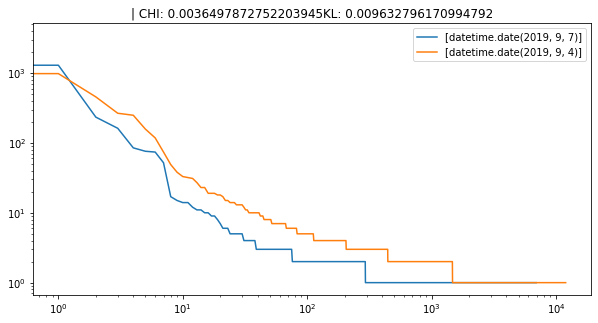

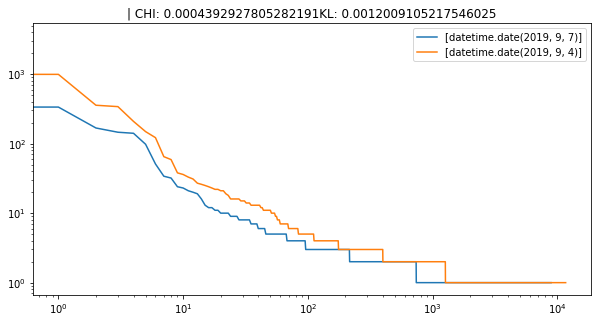

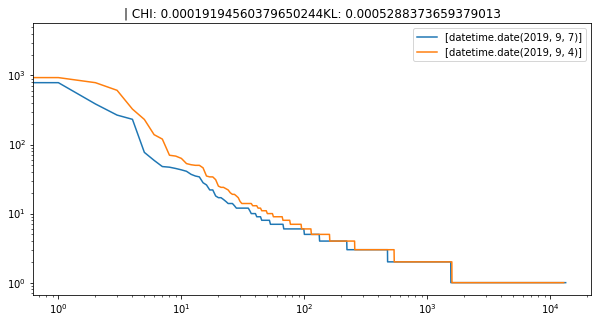

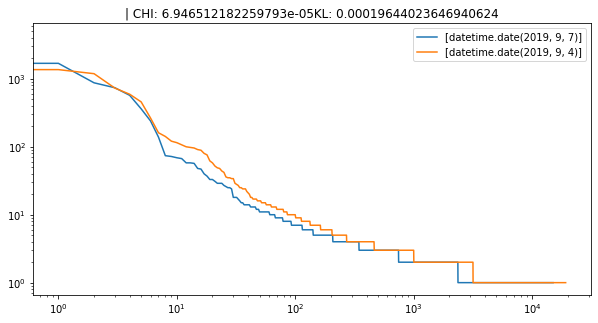

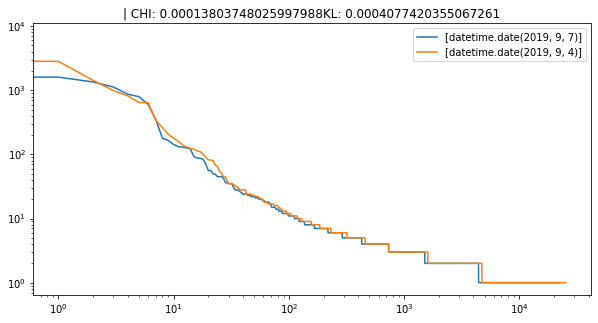

In [14]:
range = 5
for (d1, d2) in zip(dds1[0:range], dds2[0:range]):
    day1 = df[df["date"]==d1]
    day2 = df[df["date"]==d2]

    day1_sorted = sorted(day1["CumCount"])[::-1]
    day2_sorted = sorted(day2["CumCount"])[::-1]

    CHI, KL = distribution_metrics(day1_sorted, day2_sorted, 10)

    plt.figure(figsize=(10,5))
    plt.title("| CHI: " + str(CHI) + "KL: " + str(KL))
    plt.loglog(sorted(day1["CumCount"])[::-1], label = day1.date.dt.date.unique())
    plt.loglog(sorted(day2["CumCount"])[::-1], label = day2.date.dt.date.unique())
    plt.legend()

    plt.show()
